# Traitement images

### 1. Importation et préparation des données

In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing, cluster, metrics, manifold, decomposition
from os import listdir
from matplotlib.image import imread
import os
import time
import cv2
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve
from glob import glob

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout 
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

from scipy.optimize import linear_sum_assignment

%matplotlib inline

In [140]:
data = pd.read_csv('flipkart_com-ecommerce_sample_1050.csv')

Séparation de la colonne product_category_tree pour ne retenir que le premier niveau de classification

In [141]:
data['Category_Level_1'] = data['product_category_tree'].str.split('>>', expand=True)[0]

data['Category_Level_1'] = data['Category_Level_1'].str.replace('["', '', regex=False)

In [142]:
columns_of_interest= ['Category_Level_1', 'image']
df = data[columns_of_interest]
le = preprocessing.LabelEncoder()
df["label"] = le.fit_transform(df["Category_Level_1"])

/var/folders/xy/0lf4cqg97cq6qg1y7t6fp0sw0000gn/T/ipykernel_19174/1101903906.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["label"] = le.fit_transform(df["Category_Level_1"])


In [143]:
df

Category_Level_1                                 image  label
0     Home Furnishing   55b85ea15a1536d46b7190ad6fff8ce7.jpg      4
1           Baby Care   7b72c92c2f6c40268628ec5f14c6d590.jpg      0
2           Baby Care   64d5d4a258243731dc7bbb1eef49ad74.jpg      0
3     Home Furnishing   d4684dcdc759dd9cdf41504698d737d8.jpg      4
4     Home Furnishing   6325b6870c54cd47be6ebfbffa620ec7.jpg      4
...                ...                                   ...    ...
1045        Baby Care   958f54f4c46b53c8a0a9b8167d9140bc.jpg      0
1046        Baby Care   fd6cbcc22efb6b761bd564c28928483c.jpg      0
1047        Baby Care   5912e037d12774bb73a2048f35a00009.jpg      0
1048        Baby Care   c3edc504d1b4f0ba6224fa53a43a7ad6.jpg      0
1049        Baby Care   f2f027ad6a6df617c9f125173da71e44.jpg      0

[1050 rows x 3 columns]

In [144]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Category_Level_1  1050 non-null   object
 1   image             1050 non-null   object
 2   label             1050 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 24.7+ KB


In [145]:
df.groupby("Category_Level_1").count()

image  label
Category_Level_1                         
Baby Care                      150    150
Beauty and Personal Care       150    150
Computers                      150    150
Home Decor & Festive Needs     150    150
Home Furnishing                150    150
Kitchen & Dining               150    150
Watches                        150    150

In [146]:
image_folder = '/Users/amira/Documents/OPC/Projet6/Images/'

list_photos = [os.path.join(image_folder, img_name) for img_name in df['image']]
print(len(list_photos))

1050


In [147]:
df['image_path'] = image_folder + df['image']

/var/folders/xy/0lf4cqg97cq6qg1y7t6fp0sw0000gn/T/ipykernel_19174/426650416.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['image_path'] = image_folder + df['image']


In [148]:
df

Category_Level_1                                 image  label  \
0     Home Furnishing   55b85ea15a1536d46b7190ad6fff8ce7.jpg      4   
1           Baby Care   7b72c92c2f6c40268628ec5f14c6d590.jpg      0   
2           Baby Care   64d5d4a258243731dc7bbb1eef49ad74.jpg      0   
3     Home Furnishing   d4684dcdc759dd9cdf41504698d737d8.jpg      4   
4     Home Furnishing   6325b6870c54cd47be6ebfbffa620ec7.jpg      4   
...                ...                                   ...    ...   
1045        Baby Care   958f54f4c46b53c8a0a9b8167d9140bc.jpg      0   
1046        Baby Care   fd6cbcc22efb6b761bd564c28928483c.jpg      0   
1047        Baby Care   5912e037d12774bb73a2048f35a00009.jpg      0   
1048        Baby Care   c3edc504d1b4f0ba6224fa53a43a7ad6.jpg      0   
1049        Baby Care   f2f027ad6a6df617c9f125173da71e44.jpg      0   

                                             image_path  
0     /Users/amira/Documents/OPC/Projet6/Images/55b8...  
1     /Users/amira/Documents/OPC/Projet6/Images/7b72...  
2     /Users/amira/Documents/OPC/Projet6/Images/64d5...  
3     /Users/amira/Documents/OPC/Projet6/Images/d468...  
4     /Users/amira/Documents/OPC/Projet6/Images/6325...  
...                                                 ...  
1045  /Users/amira/Documents/OPC/Projet6/Images/958f...  
1046  /Users/amira/Documents/OPC/Projet6/Images/fd6c...  
1047  /Users/amira/Documents/OPC/Projet6/Images/5912...  
1048  /Users/amira/Documents/OPC/Projet6/Images/c3ed...  
1049  /Users/amira/Documents/OPC/Projet6/Images/f2f0...  

[1050 rows x 4 columns]

### 2. Technique basique de traitement image 

#### 2.1. Affichage des images

Home Furnishing 


Baby Care 


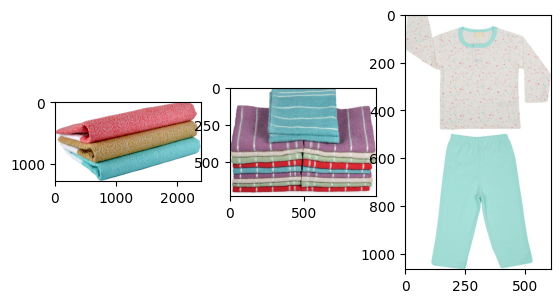

Watches 


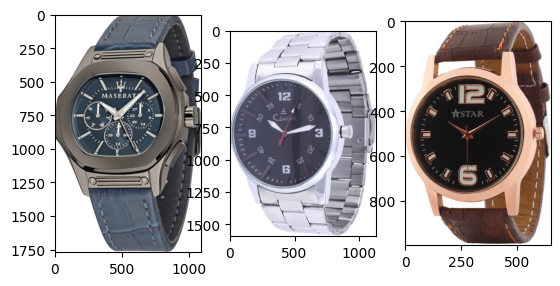

Home Decor & Festive Needs 


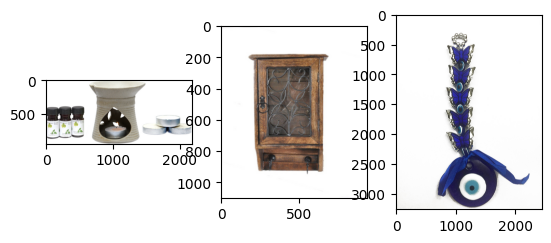

Kitchen & Dining 


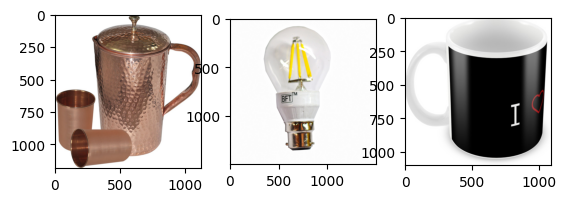

Beauty and Personal Care 


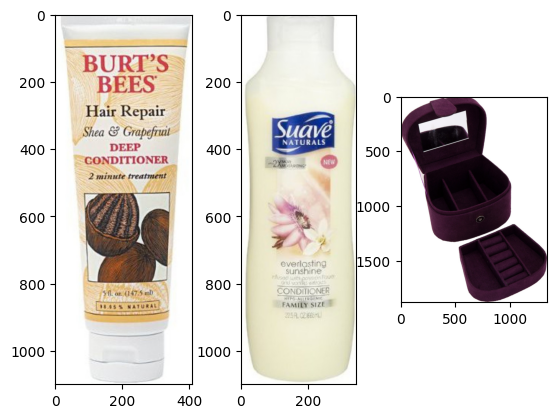

Computers 


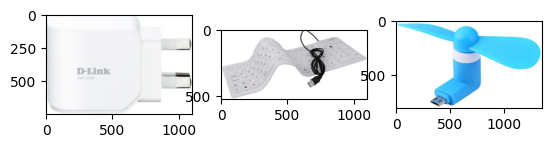

In [149]:
list_categories = df['Category_Level_1'].unique().tolist()

def list_fct(name):
    return [list_photos[i] for i in range(len(df)) if df["Category_Level_1"][i] == name]

for name in list_categories:
    print(name)
    
    for i in range(3):
        plt.subplot(130 + 1 + i)  
        filename = list_fct(name)[i]  
        image = imread(filename)  
        plt.imshow(image)  
    
    plt.show()  

#### 2.2. Pré-traitement des images (SIFT)

- Chargement de l'image en niveaux de gris 
- Égalisation de l'histogramme
- Détection des points clés et calcul des descripteurs par image (nécessaire pour la détermination des histogrammes par la suite)
- Concaténation des descripteurs de toutes les images (nécessaire pour le clustering par la suite)

In [150]:
results_time = pd.DataFrame(columns=['Méthode', 'Temps exécution'])

In [151]:
start_time = time.time()

sift_keypoints = []
sift = cv2.SIFT_create(500)

for image_num in range(len(list_photos)):
    if image_num % 100 == 0:
            print(f"Traitement de l'image numéro {image_num}...")

    image = cv2.imread(list_photos[image_num], 0)  
        
    if image is None:
            print(f"Erreur lors du chargement de l'image : {list_photos[image_num]}")
            continue

    res = cv2.equalizeHist(image)

    kp, des = sift.detectAndCompute(res, None)

    sift_keypoints.append(des)

sift_keypoints_by_img = np.asarray(sift_keypoints, dtype=object)
sift_keypoints_all    = np.concatenate(sift_keypoints_by_img, axis=0)

end_time = time.time()  
execution_time_1 = end_time - start_time
results_time = results_time.append({'Méthode': 'Technique basique SIFT', 'Temps exécution': execution_time_1}, ignore_index=True)

Traitement de l'image numéro 0...
Traitement de l'image numéro 100...
Traitement de l'image numéro 200...
Traitement de l'image numéro 300...
Traitement de l'image numéro 400...
Traitement de l'image numéro 500...
Traitement de l'image numéro 600...
Traitement de l'image numéro 700...
Traitement de l'image numéro 800...
Traitement de l'image numéro 900...
Traitement de l'image numéro 1000...


/var/folders/xy/0lf4cqg97cq6qg1y7t6fp0sw0000gn/T/ipykernel_19174/90521138.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_time = results_time.append({'Méthode': 'Technique basique SIFT', 'Temps exécution': execution_time_1}, ignore_index=True)


#### 2.3. Clustering des descripteurs

In [152]:
k = int(round(np.sqrt(len(sift_keypoints_all)),0))
print("Nombre de clusters estimés : ", k)
print("Création de",k, "clusters de descripteurs ...")

kmeans = cluster.MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=42)
kmeans.fit(sift_keypoints_all)

Nombre de clusters estimés :  719
Création de 719 clusters de descripteurs ...


MiniBatchKMeans(init_size=2157, n_clusters=719, random_state=42)

#### 2.4. Détermination des features

Transformation des descripteurs SIFT de chaque image en vecteurs de caractéristiques (histogrammes) par quantification des descripteurs à l'aide d'un modèle k-means

In [153]:
def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist

hist_vectors=[]

for i, image_desc in enumerate(sift_keypoints_by_img) :
    if i%100 == 0 : print(i)  
    hist = build_histogram(kmeans, image_desc, i) 
    hist_vectors.append(hist) 

im_features = np.asarray(hist_vectors)


0
100
200
300
400
500
600
700
800
900
1000


#### 2.5. Réduction de dimension

Par ACP

In [154]:
print("Dimensions dataset avant réduction PCA : ", im_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(im_features)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 719)
Dimensions dataset après réduction PCA :  (1050, 507)


Par t-SNE

In [155]:
tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=42)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = df["Category_Level_1"]
print(df_tsne.shape)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


(1050, 3)


#### 2.6. t-SNE des catégories réelles

In [156]:
colors = ['red', 'darkviolet', 'grey', 'saddlebrown','lightpink', 'blue', 'darkorange']
custom_palette = sns.color_palette(colors)

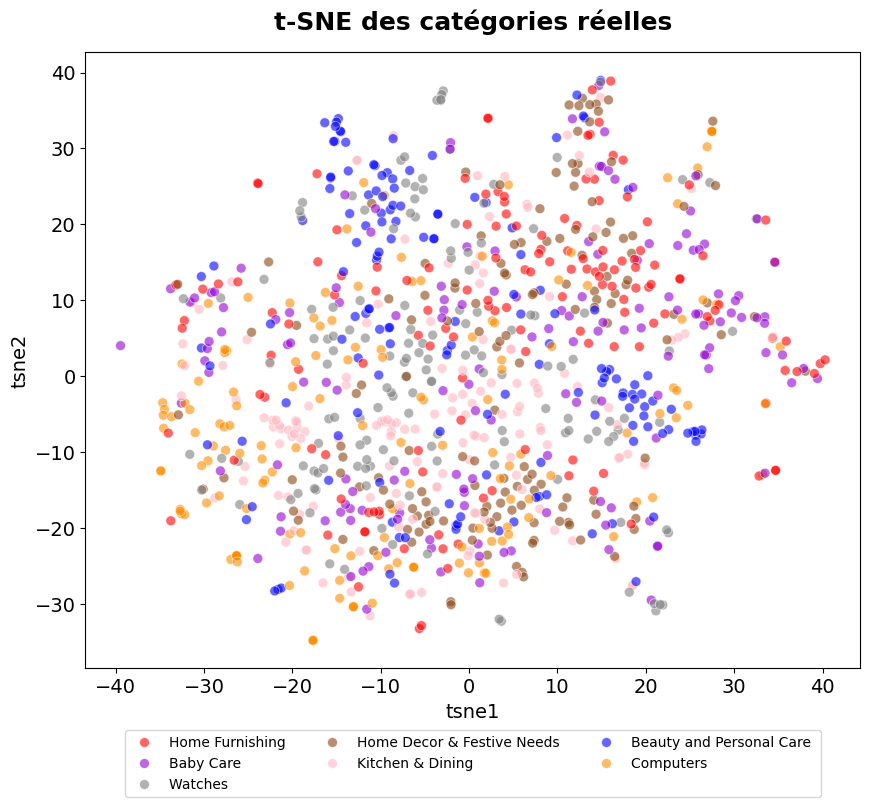

In [157]:
plt.figure(figsize=(10,8))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=custom_palette, s=50, alpha=0.6)

plt.title('t-SNE des catégories réelles', fontsize=18, pad=16, fontweight='bold')

plt.xlabel('tsne1', fontsize=14)
plt.ylabel('tsne2', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


plt.legend(prop={'size': 10}, bbox_to_anchor=(0.5, -0.1), loc='upper center', borderaxespad=0., ncol=3)

plt.show()


#### 2.7. Comparaison catégories réelles et prédites

In [158]:
cls = cluster.KMeans(n_clusters=7, random_state=42)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)

(1050, 4)


#### 2.8. t-SNE des catégories prédites (clusters) et calcul ARI

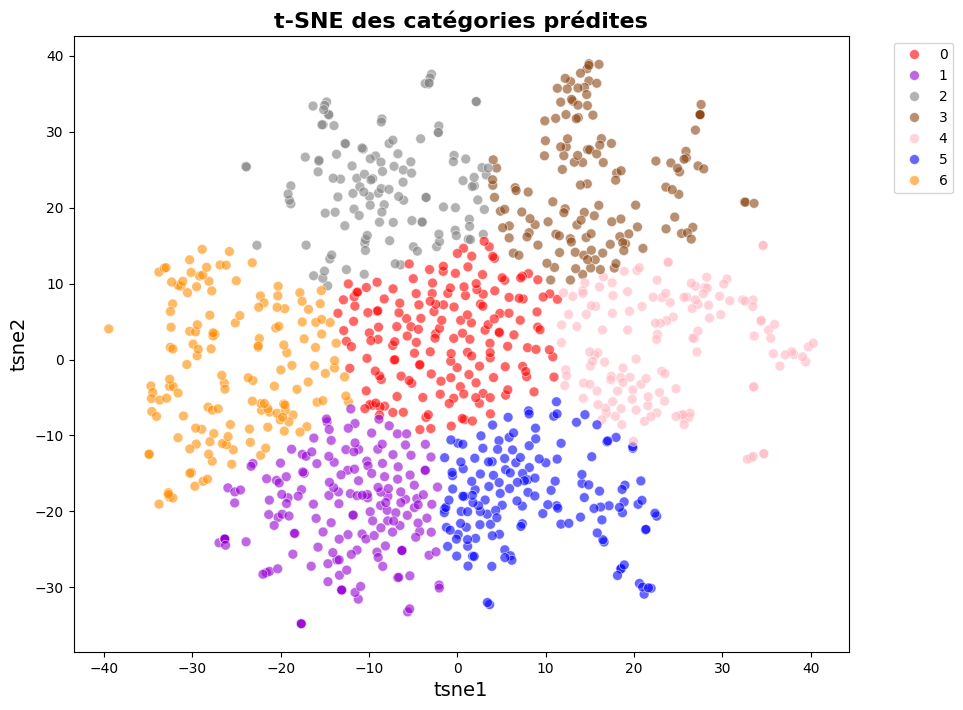

In [159]:
plt.figure(figsize=(10,8))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=custom_palette, s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('t-SNE des catégories prédites', fontsize=16, fontweight='bold')

plt.xlabel('tsne1', fontsize=14)
plt.ylabel('tsne2', fontsize=14)

plt.legend(prop={'size': 10}, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


In [160]:
results_ari = pd.DataFrame(columns=['Méthode', 'ARI'])

In [161]:
labels = df["label"]
ari_1= metrics.adjusted_rand_score(labels, cls.labels_)


In [162]:
results_ari = results_ari.append({'Méthode': 'Technique basique SIFT', 'ARI': ari_1}, ignore_index=True)

/var/folders/xy/0lf4cqg97cq6qg1y7t6fp0sw0000gn/T/ipykernel_19174/1146899454.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_ari = results_ari.append({'Méthode': 'Technique basique SIFT', 'ARI': ari_1}, ignore_index=True)


In [163]:
df_tsne.groupby("cluster").count()["class"]

cluster
0    173
1    172
2    124
3    138
4    140
5    151
6    152
Name: class, dtype: int64

#### 2.9. Matrice de confusion

Correspondance des clusters :  [6 5 1 4 0 3 2]
[[36  9 23 20 21 23 18]
 [33 47 10 15  8 14 23]
 [12  8 46 22 12 36 14]
 [13  6  7 40 38 26 20]
 [29 18 16  9 44 18 16]
 [ 7  8 31 26  9 28 41]
 [10 28 19 19  6 27 41]]

              precision    recall  f1-score   support

           0       0.26      0.24      0.25       150
           1       0.38      0.31      0.34       150
           2       0.30      0.31      0.30       150
           3       0.26      0.27      0.27       150
           4       0.32      0.29      0.31       150
           5       0.16      0.19      0.17       150
           6       0.24      0.27      0.25       150

    accuracy                           0.27      1050
   macro avg       0.27      0.27      0.27      1050
weighted avg       0.27      0.27      0.27      1050



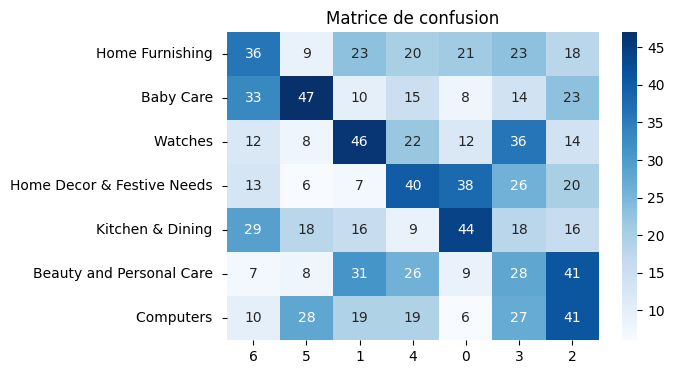

In [164]:
def conf_mat_transform(y_true, y_pred):
    conf_mat = metrics.confusion_matrix(y_true, y_pred)
    
    row_ind, col_ind = linear_sum_assignment(-conf_mat)
    
    corresp = np.zeros(conf_mat.shape[1], dtype=int)
    for i, j in enumerate(col_ind):
        corresp[j] = row_ind[i]
    
    print("Correspondance des clusters : ", corresp)
    
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x: corresp[x])
    
    return labels['y_pred_transform']

cls_labels_transform = conf_mat_transform(labels, cls.labels_)
conf_mat = metrics.confusion_matrix(labels, cls_labels_transform)

print(conf_mat)
print()
print(metrics.classification_report(labels, cls_labels_transform))

df_cm = pd.DataFrame(conf_mat, index=[label for label in list_categories],
                     columns=[i for i in "6514032"])

plt.figure(figsize=(6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")
plt.title('Matrice de confusion')
plt.show()


#### 2.10. Exemple pour 3 images aléatoires

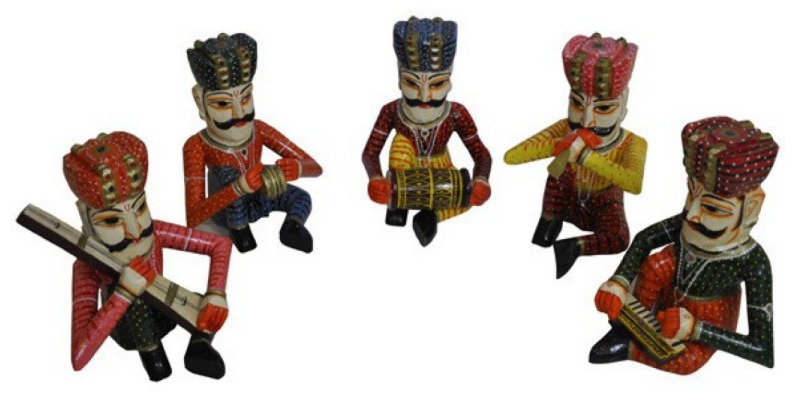

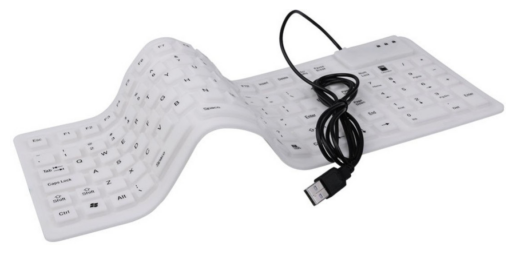

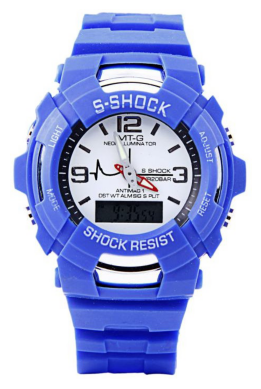

In [165]:
random.seed(42)
random_images = random.sample(range(len(df)), 3)
# Affichage des images sélectionnées
plt.figure(figsize=(10, 10))
for i, img_idx in enumerate(random_images):
    img_path = df.iloc[img_idx]['image_path']  # Remplacer 'image_path' par le nom de la colonne contenant les chemins
    img = plt.imread(img_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

L'image sélectionnée est la numéro : 228, Catégorie : Home Decor & Festive Needs 


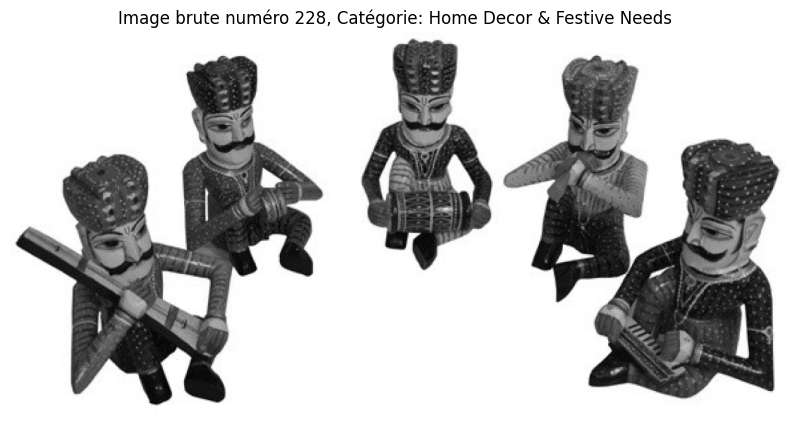

L'image numéro 228 a été assignée au cluster : 5
La catégorie réelle de l'image numéro 228 est : Home Decor & Festive Needs 
L'image sélectionnée est la numéro : 51, Catégorie : Computers 


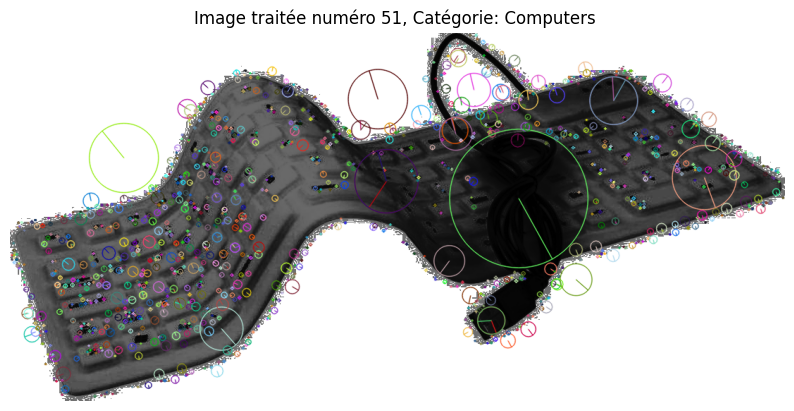

L'image numéro 51 a été assignée au cluster : 1
La catégorie réelle de l'image numéro 51 est : Computers 
L'image sélectionnée est la numéro : 563, Catégorie : Watches 


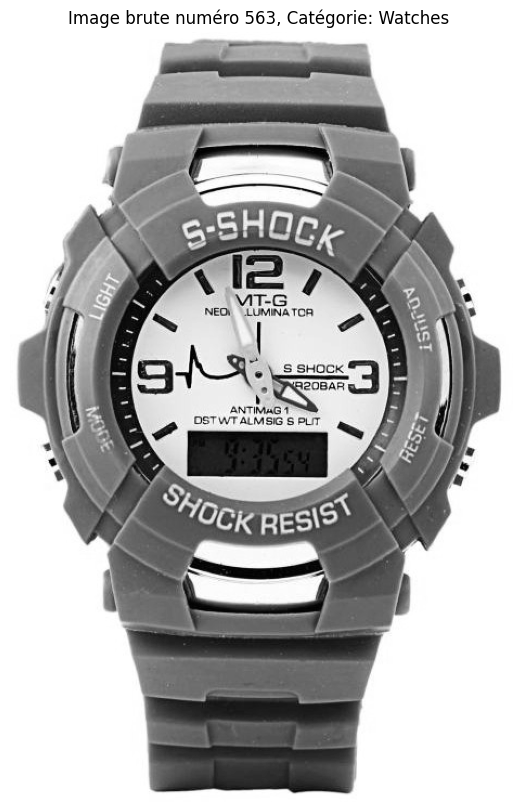

L'image numéro 563 a été assignée au cluster : 2
La catégorie réelle de l'image numéro 563 est : Watches 


In [166]:
for idx, image_num in enumerate(random_images):
    image_name = df.iloc[image_num]['image'] 
    category = df.iloc[image_num]['Category_Level_1'] 
    
    image_path = os.path.join(image_folder, image_name)

    print(f"L'image sélectionnée est la numéro : {image_num}, Catégorie : {category}")

    image = cv2.imread(image_path, 0)

    if image is None:
        print(f"Erreur lors du chargement de l'image : {image_path}")
        continue

    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='gray')
    plt.title(f"Image brute numéro {image_num}, Catégorie: {category}")
    plt.axis('off')
    plt.show()

    res = cv2.equalizeHist(image)

    sift = cv2.SIFT_create()
    kp, des = sift.detectAndCompute(res, None)

    image_with_keypoints = cv2.drawKeypoints(res, kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    plt.figure(figsize=(10, 10))
    plt.imshow(image_with_keypoints, cmap='gray')
    plt.title(f"Image traitée numéro {image_num}, Catégorie: {category}")
    plt.axis('off')
    plt.show()

    cluster_image_num = df_tsne.loc[image_num, "cluster"]
    print(f"L'image numéro {image_num} a été assignée au cluster : {cluster_image_num}")

    label_image_num = df_tsne.loc[image_num, "class"]
    print(f"La catégorie réelle de l'image numéro {image_num} est : {label_image_num}")


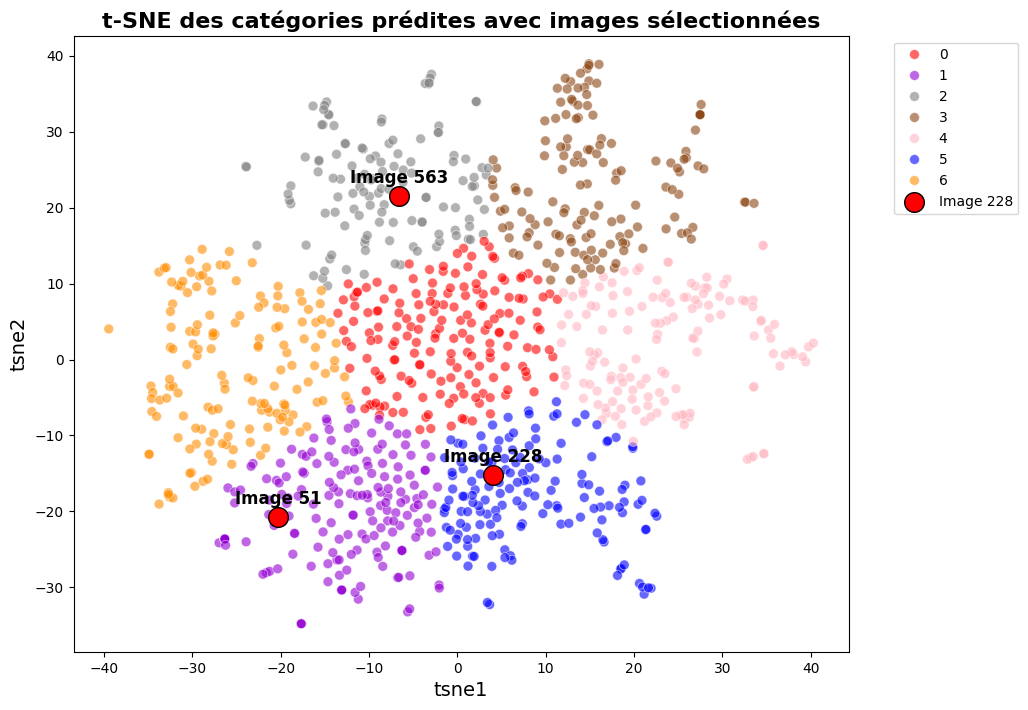

In [167]:
plt.figure(figsize=(10,8))

sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=custom_palette, s=50, alpha=0.6,
    data=df_tsne,
    legend="brief"
)

for image_num in random_images:
    x, y = df_tsne.loc[image_num, 'tsne1'], df_tsne.loc[image_num, 'tsne2']
    
    plt.scatter(x, y, s=200, c='red', edgecolor='black', marker='o', label=f"Image {image_num}" if image_num == random_images[0] else "")
    
    plt.annotate(f"Image {image_num}", (x, y), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=12, fontweight='bold')

plt.title('t-SNE des catégories prédites avec images sélectionnées', fontsize=16, fontweight='bold')

plt.xlabel('tsne1', fontsize=14)
plt.ylabel('tsne2', fontsize=14)

plt.legend(prop={'size': 10}, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


### 3. Technique Transfert Learning

#### 3.1. Création du modèle pré-entraîné

In [168]:
base_model = VGG16()
model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)

print(model.summary())

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


#### 3.2. Création des features des images

In [169]:
start_time = time.time()

images_features = []
i=0 
for image_file in df["image_path"] :
    if i%100 == 0 : print(i)
    i +=1
    image = load_img(image_file, target_size=(224, 224))
    image = img_to_array(image) 
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    images_features.append(model.predict(image, verbose=0)[0]) 

images_features = np.asarray(images_features)
images_features.shape

end_time = time.time()  
execution_time_2 = end_time - start_time
results_time = results_time.append({'Méthode': 'Technique Transfert learning', 'Temps exécution': execution_time_2}, ignore_index=True)

0
100
200
300
400
500
600


/opt/anaconda3/lib/python3.11/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


700
800
900
1000


/var/folders/xy/0lf4cqg97cq6qg1y7t6fp0sw0000gn/T/ipykernel_19174/4239050988.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_time = results_time.append({'Méthode': 'Technique Transfert learning', 'Temps exécution': execution_time_2}, ignore_index=True)


#### 3.3. Réduction de dimension

Par ACP

In [170]:
print(images_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(images_features)
print(feat_pca.shape)

(1050, 4096)
(1050, 803)


Par t-SNE

In [171]:
tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, init='random', random_state=42)
X_tsne = tsne.fit_transform(feat_pca)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


#### 3.4. t-SNE des catégories réelles

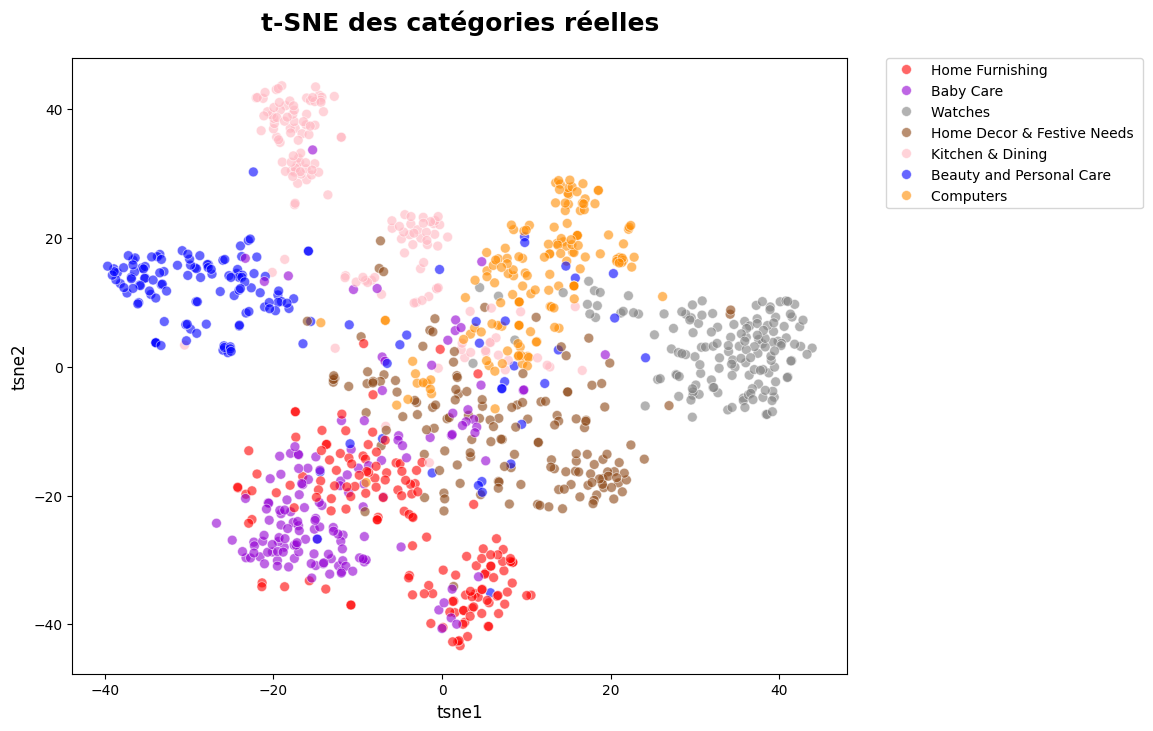

In [172]:
df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])
df_tsne["class"] = df["Category_Level_1"]

plt.figure(figsize=(10,8))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="class",
    palette=custom_palette, s=50, alpha=0.6,
    data=df_tsne,
    legend='brief')

plt.title('t-SNE des catégories réelles', fontsize = 18, pad = 20, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 12)
plt.ylabel('tsne2', fontsize = 12)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, prop={'size': 10})

plt.show()

#### 3.5. Clustering et t-SNE des clusters

In [173]:
cls = cluster.KMeans(n_clusters=7, n_init=100)
cls.fit(X_tsne)

KMeans(n_clusters=7, n_init=100)

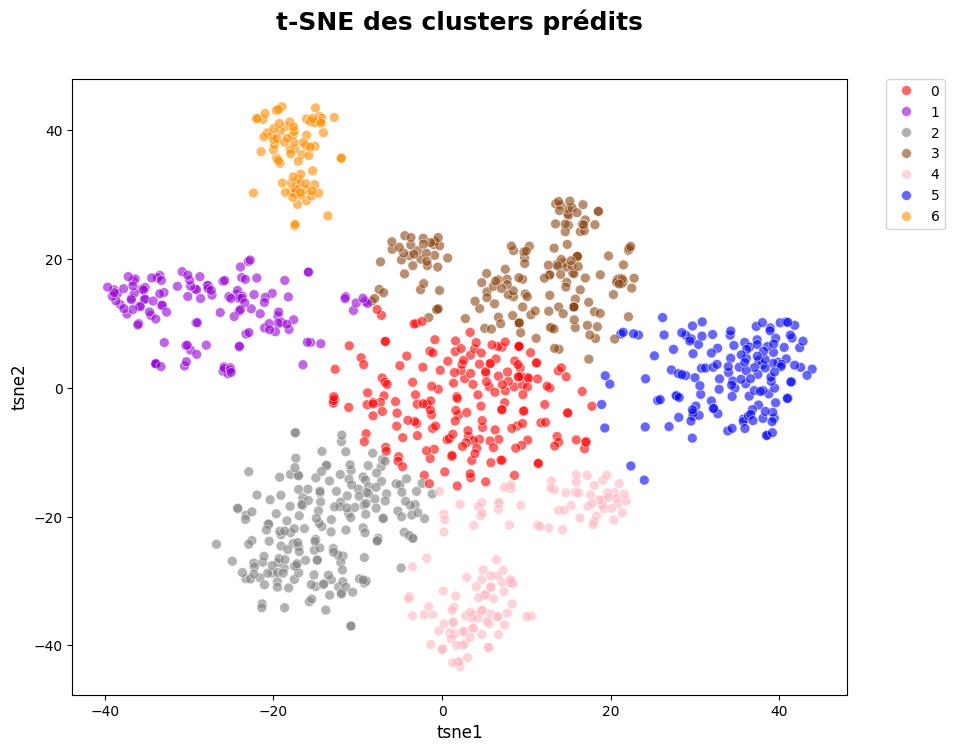

In [174]:
df_tsne["cluster"] = cls.labels_

plt.figure(figsize=(10,8))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=custom_palette, s=50, alpha=0.6,
    data=df_tsne,
    legend='brief')

plt.title('t-SNE des clusters prédits', fontsize = 18, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 12)
plt.ylabel('tsne2', fontsize = 12)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, prop={'size': 10})

plt.show()

In [175]:
labels = df["label"]

ari_2= metrics.adjusted_rand_score(labels, cls.labels_)

In [176]:
results_ari = results_ari.append({'Méthode': 'Technique Transfert learning', 'ARI': ari_2}, ignore_index=True)

/var/folders/xy/0lf4cqg97cq6qg1y7t6fp0sw0000gn/T/ipykernel_19174/2457508860.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_ari = results_ari.append({'Méthode': 'Technique Transfert learning', 'ARI': ari_2}, ignore_index=True)


#### 3.6. Matrice de confusion

In [177]:
conf_mat = metrics.confusion_matrix(labels, cls.labels_)
print(conf_mat)

[[ 27   4 109   1   7   1   1]
 [ 14 117   5   7   5   1   1]
 [ 40   1   1 107   0   1   0]
 [ 77   1   3   6  55   8   0]
 [  4   0  78   0  68   0   0]
 [ 25   9   0  38   0   0  78]
 [  2   0   0  11   0 137   0]]


In [178]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    corresp = np.argmax(conf_mat, axis=0)
    print ("Correspondance des clusters : ", corresp)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

In [179]:
cls_labels_transform = conf_mat_transform(labels, cls.labels_)
conf_mat = metrics.confusion_matrix(labels, cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(labels, cls_labels_transform))

Correspondance des clusters :  [3 1 0 2 4 6 5]
[[109   4   1  27   7   1   1]
 [  5 117   7  14   5   1   1]
 [  1   1 107  40   0   0   1]
 [  3   1   6  77  55   0   8]
 [ 78   0   0   4  68   0   0]
 [  0   9  38  25   0  78   0]
 [  0   0  11   2   0   0 137]]

              precision    recall  f1-score   support

           0       0.56      0.73      0.63       150
           1       0.89      0.78      0.83       150
           2       0.63      0.71      0.67       150
           3       0.41      0.51      0.45       150
           4       0.50      0.45      0.48       150
           5       0.97      0.52      0.68       150
           6       0.93      0.91      0.92       150

    accuracy                           0.66      1050
   macro avg       0.70      0.66      0.67      1050
weighted avg       0.70      0.66      0.67      1050



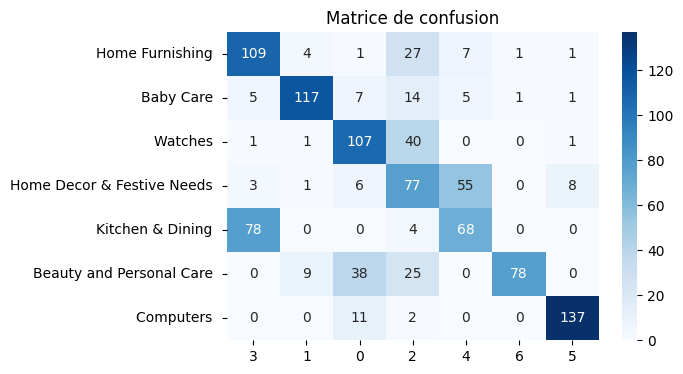

In [183]:
list_labels = df['Category_Level_1'].unique()

df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in "3102465"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues", fmt='g')
plt.title('Matrice de confusion')
plt.show()

### 4. Conclusion

In [181]:
results = pd.merge(results_ari, results_time, on='Méthode', how='inner')
results['ARI'] = results['ARI'].round(3)
results['Temps exécution (min)'] = (results['Temps exécution'] / 60).round(3)
results = results.drop(columns=['Temps exécution'])

results

Méthode    ARI  Temps exécution (min)
0        Technique basique SIFT  0.042                 15.322
1  Technique Transfert learning  0.451                  8.548

- Technique basique SIFT : ARI = 0.042, ce qui signifie que la technique SIFT donne un résultat très proche du hasard. La méthode ne parvient donc pas à bien classifier les images
- Technique Transfert learning : ARI = 0.451, ce qui montre une bien meilleure performance. Ce résultat est significativement plus élevé, mais pas parfait. Cela indique une capacité raisonnable à bien classer les produits, bien que des améliorations soient possibles.
La technique de transfert d'apprentissage est clairement supérieure à la méthode basique SIFT à la fois en termes de précision et de temps d'exécution. Elle constitue donc un meilleur choix pour classifier des produits selon leur image dans cette étude.